**About this notebook**: This notebook is based on `v2 OCT TensorFlow Resnet 50 Model.ipynb`. It's purpose is to train the model using less training data, see the variable `REDUCED_FRACTION` which determines the amount of data used from the training set. This notebook is a Resnet50 implementation for retinal conditions recognition on an Retinal OCT image dataset.

**Version 2_reduced_20percent**:
- Trained using the Functional API.
- The whole network was trained with ImageNet initial weights.
- Training was done using only 20% of the training set, see `REDUCED_FRACTION = 0.2`.

**Testing** was done on 5% of the dataset, see `SPLIT_TEST_FRACTION = 0.05` below.

# Download data, mount Google Drive and configure directories

Data is downloaded from:
- [here](https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/5699a1d8-d1b6-45db-bb92-b61051445347/file_downloaded) for dataset
- Google Drive for CSV containing image index

In [ ]:
_URL = "https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/5699a1d8-d1b6-45db-bb92-b61051445347/file_downloaded"
!wget -nc {_URL} -O OCT2017.tar.gz
!tar -xf OCT2017.tar.gz

--2022-02-15 01:44:14--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/5699a1d8-d1b6-45db-bb92-b61051445347/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67 [following]
--2022-02-15 01:44:15--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.45.154
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.45.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5793183169 (5.4G) [applicat

## Mount Google Drive or use locally

**Note**: This was done inside a Google Drive directory but it has been removed from below, use your own if you plan to do this in Google Drive. Replace the part `[REPLACE THIS WITH THE LOCATION IN YOUR OWN GOOGLE DRIVE]` with your own directory inside your Google Drive.

In [ ]:
BASE_PATH = !pwd
BASE_PATH = BASE_PATH[0]

# Note
#   If using DATA_CSV_MENDELEY with ! or % , quote it so the spaces are respected
#   e.g. `!head "{DATA_CSV_MENDELEY}"`

try:  # Mount Google Drive
    import os

    from google.colab import drive

    drive.mount("/content/gdrive")
    DATA_CSV_MENDELEY_FILE = "/content/gdrive/My Drive/[REPLACE THIS WITH THE LOCATION IN YOUR OWN GOOGLE DRIVE]/data_wrangling/mendeley/mendeley_filelist_combo_cond_md5.csv"
    NOTEBOOK_DIR = (
        "/content/gdrive/My Drive/[REPLACE THIS WITH THE LOCATION IN YOUR OWN GOOGLE DRIVE]"
    )
    # !ln -s "{NOTEBOOK_DIR}" NOTEBOOK_DIR
    !if [ -e NOTEBOOK_DIR ]; then echo 'NOTEBOOK_DIR link already exists'; else ln -s "{NOTEBOOK_DIR}" NOTEBOOK_DIR; fi
except:  # Locally run Jupyter
    DATA_CSV_MENDELEY_FILE = "../../data_wrangling/mendeley/mendeley_filelist_combo_cond_md5.csv"
    NOTEBOOK_DIR = f"{BASE_PATH}"

Mounted at /content/gdrive


# Import stuff

In [ ]:
import math
import os
import time
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as kbackend
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Config

In [ ]:
# Model input size
IMAGE_SIZE = (256, 256)

# Fraction of data used for test, from total
# Training fraction is (1-SPLIT_TEST_FRACTION)
SPLIT_TEST_FRACTION = 0.05

# Fraction of data used for the reduced training data, from training
REDUCED_FRACTION = 0.2

# Fraction of data used for validation, from the train split
#   (train split is total minus SPLIT_TEST_FRACTION)
SPLIT_VALIDATION_FRACTION = 0.2

# Training configuration
BATCH_SIZE = 16
LEARNING_RATE = 0.01
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# To save the model
VERSION = "v2_reduced_20percent"

# Import CSV into Pandas DataFrame and add one hot colums

In [ ]:
df_original = pd.read_csv(f"{DATA_CSV_MENDELEY_FILE}", index_col=0)
df_original.head(2)

,file_name,dataset,condition,file_location,patient_id,md5,dimensions
0,CNV-4283050-2.jpeg,test,CNV,OCT2017/test/CNV/CNV-4283050-2.jpeg,4283050,194c039768e730812cf77c2072821f83,"(512, 496)"
1,CNV-909994-1.jpeg,test,CNV,OCT2017/test/CNV/CNV-909994-1.jpeg,909994,5b35e52a54e99ef5195e4a715054ac09,"(512, 496)"


In [ ]:
df_original.value_counts("condition")

condition
CNV       31649
NORMAL    26304
DME       11148
DRUSEN     8026
dtype: int64

In [ ]:
df = pd.concat([df_original, pd.get_dummies(df_original["condition"])], axis=1)
df.sample(5, random_state=42)

,file_name,dataset,condition,file_location,patient_id,md5,dimensions,CNV,DME,DRUSEN,NORMAL
61170,NORMAL-3758622-1.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-3758622-1.jpeg,3758622,5ee880dd90064fbcd8a3a568263b8f7b,"(512, 512)",0,0,0,1
66965,NORMAL-4218655-1.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-4218655-1.jpeg,4218655,7e0dabc889fdab262cc69c66bdc03f72,"(512, 512)",0,0,0,1
17478,CNV-9547888-38.jpeg,train,CNV,OCT2017/train/CNV/CNV-9547888-38.jpeg,9547888,b2f345d7e7846a303386ae72aa21b400,"(512, 496)",1,0,0,0
47792,DRUSEN-7685407-5.jpeg,train,DRUSEN,OCT2017/train/DRUSEN/DRUSEN-7685407-5.jpeg,7685407,771025d3ee61b2aac7f09c857087a7db,"(512, 496)",0,0,1,0
67574,NORMAL-1056057-1.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-1056057-1.jpeg,1056057,39494ad34cc07dfce62f502481a4bffe,"(768, 496)",0,0,0,1


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

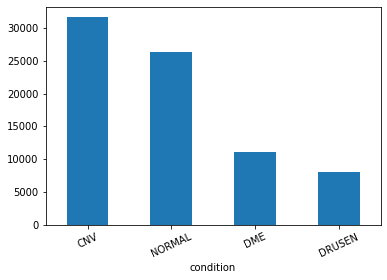

In [ ]:
df.value_counts(subset="condition").plot(kind="bar")
plt.xticks(rotation=25)

In [ ]:
# Split into train/test
# https://stackoverflow.com/a/70573258/1071459

df_test = df.sample(frac=SPLIT_TEST_FRACTION, axis=0, random_state=42)
# get everything but the test sample
df_train = df.drop(index=df_test.index)
df_train_reduced = df_train.sample(frac=REDUCED_FRACTION, axis=0, random_state=42)
f"Examples by set: df_test: {df_test.shape[0]} / df_train: {df_train.shape[0]} / df_train_reduced: {df_train_reduced.shape[0]}"

'Examples by set: df_test: 3856 / df_train: 73271 / df_train_reduced: 14654'

In [ ]:
df_train.value_counts(subset="condition", normalize=True)

condition
CNV       0.411036
NORMAL    0.340408
DME       0.144259
DRUSEN    0.104298
dtype: float64

In [ ]:
df_test.value_counts(subset="condition", normalize=True)

condition
CNV       0.397303
NORMAL    0.353216
DME       0.149896
DRUSEN    0.099585
dtype: float64

In [ ]:
df_train_reduced.value_counts(subset="condition", normalize=True)

condition
CNV       0.403439
NORMAL    0.341750
DME       0.146376
DRUSEN    0.108435
dtype: float64

In [ ]:
df_train_reduced.sample(2, random_state=42)

,file_name,dataset,condition,file_location,patient_id,md5,dimensions,CNV,DME,DRUSEN,NORMAL
48127,DRUSEN-2489093-37.jpeg,train,DRUSEN,OCT2017/train/DRUSEN/DRUSEN-2489093-37.jpeg,2489093,615387b7a521b6bc06f7c1edf17fdfef,"(512, 496)",0,0,1,0
27215,CNV-8602230-25.jpeg,train,CNV,OCT2017/train/CNV/CNV-8602230-25.jpeg,8602230,25362d1f09e0b5cb056a859196929d56,"(512, 496)",1,0,0,0


In [ ]:
df_test.sample(2, random_state=42)

,file_name,dataset,condition,file_location,patient_id,md5,dimensions,CNV,DME,DRUSEN,NORMAL
72285,NORMAL-8871445-5.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-8871445-5.jpeg,8871445,d0eaf068834b1764c3a6340751922135,"(1536, 496)",0,0,0,1
56073,NORMAL-3108219-6.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-3108219-6.jpeg,3108219,8db97d5131740615bc79b10fb46816e9,"(512, 496)",0,0,0,1


# Data Augmentation

## Creating the ImageDataGenerator and setting up it's flows

In [ ]:
image_gen = ImageDataGenerator(
    # # featurewise_center=False,
    # # samplewise_center=False,
    # # featurewise_std_normalization=False,
    # # samplewise_std_normalization=False,
    # # zca_whitening=False,
    # # zca_epsilon=1e-06,
    rotation_range=15,
    width_shift_range=0.02,
    height_shift_range=0.02,
    # # brightness_range=None,
    # # shear_range=0.0,
    zoom_range=0.15,
    # channel_shift_range=0.02,
    # fill_mode='constant',
    # # cval=0.0,
    horizontal_flip=True,
    # vertical_flip=False,
    # rescale=1/255,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    # data_format='channels_last',
    validation_split=SPLIT_VALIDATION_FRACTION,
    dtype=tf.float32,
)

image_gen_flow_df_dict = dict(
    dataframe=df_train_reduced,  # DataFrame
    directory=f"{BASE_PATH}/",
    x_col="file_location",
    y_col="condition",
    subset=None,  # Replace with 'training' or 'validation'
    # color_mode = "grayscale", # graysclale
    color_mode="rgb",  # color
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,  # default 32
    seed=42,
)

# Note: ** unpacks a dictionary and
#   `**{ **image_gen_flow_df_dict, **dict(subset='training')}`
#   unpacks the whole dictionary but overwrites subset
image_gen_flow_df_dict_train = {**image_gen_flow_df_dict, **dict(subset="training")}
image_gen_flow_df_dict_val = {**image_gen_flow_df_dict, **dict(subset="validation")}

train_generator = image_gen.flow_from_dataframe(**image_gen_flow_df_dict_train)
val_generator = image_gen.flow_from_dataframe(**image_gen_flow_df_dict_val)

# # Show classes and index value for each
# # This is for sanity check purpuses
# #   if using a the column called label this values might not correspond
# #   so we use an id directly assigned
# print(train_generator.class_indices)
# print(val_generator.class_indices)
# print('equivalence:', equivalence_label_id)

print(train_generator.class_indices)
print(val_generator.class_indices)

Found 11724 validated image filenames belonging to 4 classes.
Found 2930 validated image filenames belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


## Image visualization

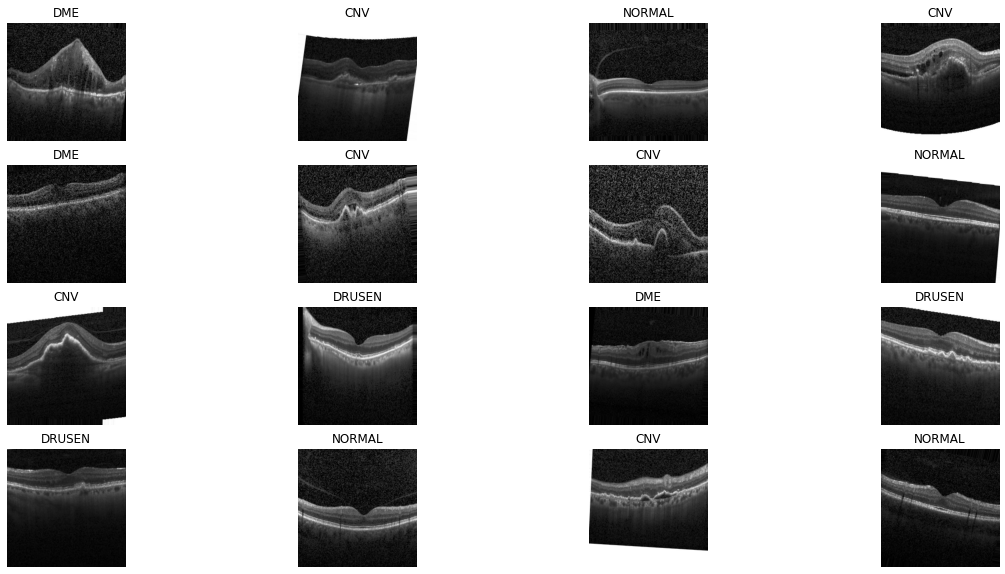

In [ ]:
x, y = train_generator.next()


def image_gbr_to_rgb_uncenter(img):
    """
    This function is used here because Resnet50 uses a function to preprocess input that wouldn't
    look right directly so a "depreprocessing" is needed.

    WARNING: This function changes the input so a copy needs to be done if the input shouldn't be changed.
    """
    img_copy = np.copy(img)
    # See code for https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/preprocess_input
    # img = np.transpose(img, (2,1,0))
    # img = np.array([img[2], img[1], img[0]])
    # img = np.transpose(img, (2,1,0))
    # ↑↓ I think this does what the three lines above do

    mean = [103.939, 116.779, 123.68]  # ImageNet dataset mean
    img_copy[..., 0] += mean[0]
    img_copy[..., 1] += mean[1]
    img_copy[..., 2] += mean[2]
    img_copy = img_copy[..., ::-1]
    img_copy = np.int0(img_copy)
    return img_copy


def plot_images(img, labels, class_names, labels_pred=None):
    """
    Plots images, if no labels_pred is given it shows the actual label.
    """

    total_imgs = np.min([25, img.shape[0]])
    width = np.int0(np.floor(np.sqrt(total_imgs)))
    height = np.int0(np.ceil(np.sqrt(total_imgs)))
    plt.figure(figsize=[20, 10])
    for i in range(np.min([25, img.shape[0]])):
        plt.subplot(width, height, i + 1)
        plt.imshow(img[i])
        if labels_pred is None:
            plt.title(
                f"{class_names[np.argmax(labels[i])]}",
                color="black",
            )
        else:
            plt.title(
                f"{class_names[labels_pred[i]]} (real: {class_names[np.argmax(labels[i])]})",
                color="black" if labels_pred[i] == np.argmax(labels[i]) else "red",
            )

        plt.axis("off")


class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # storing class/breed names in a list
x_deprocessed = image_gbr_to_rgb_uncenter(x)
plot_images(x_deprocessed, y, class_names)

# Model

## Original model architecture

This was used to visualize ResNet50's original architecture and to adapt it so it would look
as close to possible to the original.

In [ ]:
# # Uncomment to see it

# original_model = tf.keras.applications.ResNet50(
#                     #  include_top=False,
#                     #  weights='imagenet',
#                     #  input_shape=IMAGE_SIZE + (3,) # color
#                      )

# original_model.trainable = False # False to freeze the model
# original_model.summary()

## Working model

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=IMAGE_SIZE + (3,), pooling="avg"
)

base_model.trainable = True  # False to freeze the model
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
softmax_output = tf.keras.layers.Dense(4, activation="softmax")(base_model.output)
functional_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=softmax_output,
    name=f"{base_model.name}_extended_functional",
)
functional_model.summary()

Model: "resnet50_extended_functional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                       

In [ ]:
functional_model.compile(optimizer=OPTIMIZER, loss="categorical_crossentropy", metrics=["accuracy"])

# Training

**Important note**: do not run next cell unless you want to remove the output from the original training and/or run training again.

In [ ]:
# This cell is all commented out because the model has already been trained
# and we want to avoid overwriting the model files

# Callbacks
callback_early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    # restore_best_weights=True
)
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{NOTEBOOK_DIR}/{VERSION}_model_{functional_model.name}_imgsize{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_best.hdf5",
    verbose=1,
    save_best_only=True,
)
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
log_dir = f"{NOTEBOOK_DIR}/{VERSION}_model_{functional_model.name}_imgsize{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_logs"
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

time_before_fit = time.perf_counter()

# Train model
history = functional_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=30,
    callbacks=[
        # callback_early_stopping,
        callback_reduce_lr,
        callback_model_checkpoint,
        callback_tensorboard,
    ],
)

time_after_fit = time.perf_counter()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
732/732 [==============================] - ETA: 0s - loss: 1.4677 - accuracy: 0.3891
Epoch 00001: val_loss improved from inf to 1.26439, saving model to /content/gdrive/My Drive/[REPLACE THIS WITH THE LOCATION IN YOUR OWN GOOGLE DRIVE]/v2_reduced_20percent_model_resnet50_extended_functional_imgsize256x256_best.hdf5
732/732 [==============================] - 271s 348ms/step - loss: 1.4677 - accuracy: 0.3891 - val_loss: 1.2644 - val_accuracy: 0.3791 - lr: 0.0100
Epoch 2/30
732/732 [==============================] - ETA: 0s - loss: 1.2630 - accuracy: 0.3987
Epoch 00002: val_loss improved from 1.26439 to 1.24841, saving model to /content/gdrive/My Drive/[REPLACE THIS WITH THE LOCATION IN YOUR OWN GOOGLE DRIVE]/v2_reduced_20percent_model_resnet50_extended_functional_imgsize256x256_best.hdf5
732/732 [==============================] - 251s 343ms/step - loss: 1.2630 - accuracy: 0.3987 - val_loss: 1.2484 - val_accuracy: 0.3952 - lr: 0.0100
Epoch 3/30
732/732 [========================

In [ ]:
def elapsed_time(perf_counter_stop, perf_counter_start):
    _seconds_full = math.ceil(perf_counter_stop - perf_counter_start)
    _seconds = _seconds_full % 60
    _minutes_full = _seconds_full // 60
    _minutes = _minutes_full % 60
    _hours_full = _minutes_full // 60
    print(f"Elapsed time: {_hours_full} hours {_minutes} min {_seconds} seconds")


elapsed_time(time_after_fit, time_before_fit)

Elapsed time: 2 hours 3 min 9 seconds


The final model was saved so if more training was needed this would be the starting point.

**Important note**: do not run next cell unless you want to remove the output from the original training and/or run training again.

In [ ]:
# This cell is all commented out because the model has already been trained
# and we want to avoid overwriting the model files

functional_model.save(
    f"{NOTEBOOK_DIR}/{VERSION}_model_{functional_model.name}_imgsize{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_last.hdf5"
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Training visualization

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


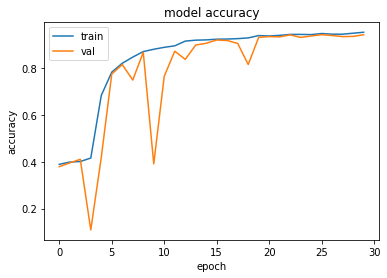

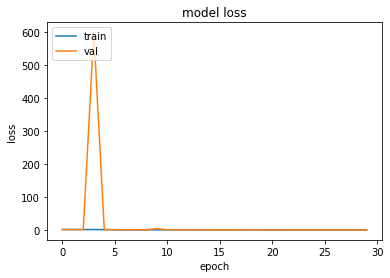

In [ ]:
def plot_history(history):
    # This function will plot the model fit process
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()
    # summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()


plot_history(history)

# Test set predictions

## Load model from training to obtain test metrics

In [ ]:
functional_model_for_testing = tf.keras.models.load_model(
    f"{NOTEBOOK_DIR}/{VERSION}_model_{functional_model.name}_imgsize{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_best.hdf5"
)

## Image obtaining

In [ ]:
# ImageDataGenerator is used to obtain the images from the test set without augmentations
test_image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    dtype=tf.float32,
)

test_generator = test_image_gen.flow_from_dataframe(
    dataframe=df_test,  # DataFrame
    directory=f"{BASE_PATH}/",
    x_col="file_location",
    y_col="condition",
    color_mode="rgb",  # color
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    shuffle=False,  # IMPORTANT: Set to False to avoid changing the orden from the dataframe
    batch_size=BATCH_SIZE,  # default 32
)

print(test_generator.class_indices)

Found 3856 validated image filenames belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


## Basic evaluation

In [ ]:
evaluation = functional_model_for_testing.evaluate(test_generator)
evaluation

241/241 [==============================] - 19s 78ms/step - loss: 0.1791 - accuracy: 0.9409


[0.17909106612205505, 0.9408713579177856]

## Actual prediction

In [ ]:
df_test.head(3)

,file_name,dataset,condition,file_location,patient_id,md5,dimensions,CNV,DME,DRUSEN,NORMAL
61170,NORMAL-3758622-1.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-3758622-1.jpeg,3758622,5ee880dd90064fbcd8a3a568263b8f7b,"(512, 512)",0,0,0,1
66965,NORMAL-4218655-1.jpeg,train,NORMAL,OCT2017/train/NORMAL/NORMAL-4218655-1.jpeg,4218655,7e0dabc889fdab262cc69c66bdc03f72,"(512, 512)",0,0,0,1
17478,CNV-9547888-38.jpeg,train,CNV,OCT2017/train/CNV/CNV-9547888-38.jpeg,9547888,b2f345d7e7846a303386ae72aa21b400,"(512, 496)",1,0,0,0


In [ ]:
y_test = df_test["condition"].map(test_generator.class_indices).to_numpy()
y_test[:3]

array([3, 3, 0])

In [ ]:
prediction_full = functional_model_for_testing.predict(test_generator)
prediction_full
prediction_class = np.argmax(prediction_full, axis=-1)

In [ ]:
# Some prediction visualization for debug purposes
print(f"prediction_full.shape: {prediction_full.shape}")
print(f"prediction_class.shape: {prediction_class.shape}")
print(f"prediction_full[:3]:\n{prediction_full[:3]}")
print(f"prediction_class[:3]: {prediction_class[:3]}")

prediction_full.shape: (3856, 4)
prediction_class.shape: (3856,)
prediction_full[:3]:
[[2.2064127e-05 1.5109533e-03 9.8909973e-04 9.9747795e-01]
 [4.3783692e-04 4.9744942e-03 6.3006982e-02 9.3158078e-01]
 [8.9593595e-01 9.1032509e-04 1.0276145e-01 3.9233651e-04]]
prediction_class[:3]: [3 3 0]


## Prediction visualization

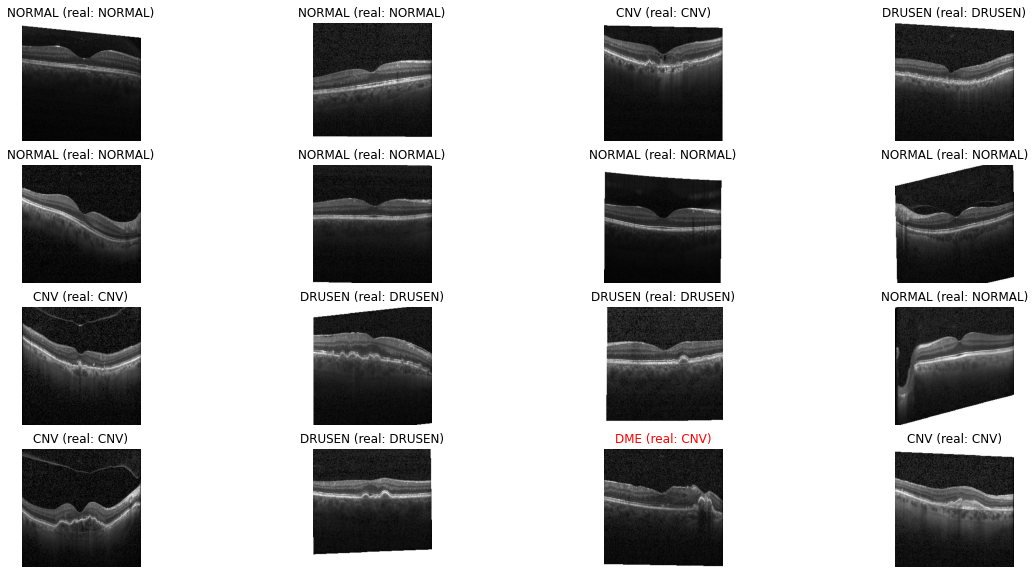

In [ ]:
batch_position = 0
x, y = test_generator[batch_position]
first_element_position = x.shape[0] * batch_position


class_indices = test_generator.class_indices
class_names = list(class_indices.keys())  # storing class/breed names in a list
x_deprocessed = image_gbr_to_rgb_uncenter(x)
plot_images(
    x_deprocessed,
    y,
    class_names,
    prediction_class[first_element_position : (first_element_position + x.shape[0])],
)

## Metrics

### Classification report

In [ ]:
report_printable = classification_report(
    y_test, prediction_class, target_names=test_generator.class_indices
)
report_dict = classification_report(
    y_test,
    prediction_class,
    target_names=test_generator.class_indices,
    output_dict=True,
)
print(report_printable)

              precision    recall  f1-score   support

         CNV       0.97      0.93      0.95      1532
         DME       0.94      0.89      0.92       578
      DRUSEN       0.79      0.90      0.85       384
      NORMAL       0.95      0.98      0.97      1362

    accuracy                           0.94      3856
   macro avg       0.92      0.93      0.92      3856
weighted avg       0.94      0.94      0.94      3856



In [ ]:
report_df = pd.DataFrame(report_dict)
report_df

,CNV,DME,DRUSEN,NORMAL,accuracy,macro avg,weighted avg
precision,0.974079,0.943119,0.794050,0.950994,0.940871,0.915561,0.943356
recall,0.932115,0.889273,0.903646,0.983113,0.940871,0.927037,0.940871
f1-score,0.952635,0.915405,0.845311,0.966787,0.940871,0.920034,0.941365
support,1532.000000,578.000000,384.000000,1362.000000,0.940871,3856.000000,3856.000000


In [ ]:
report_df.iloc[:-1, :]

,CNV,DME,DRUSEN,NORMAL,accuracy,macro avg,weighted avg
precision,0.974079,0.943119,0.794050,0.950994,0.940871,0.915561,0.943356
recall,0.932115,0.889273,0.903646,0.983113,0.940871,0.927037,0.940871
f1-score,0.952635,0.915405,0.845311,0.966787,0.940871,0.920034,0.941365


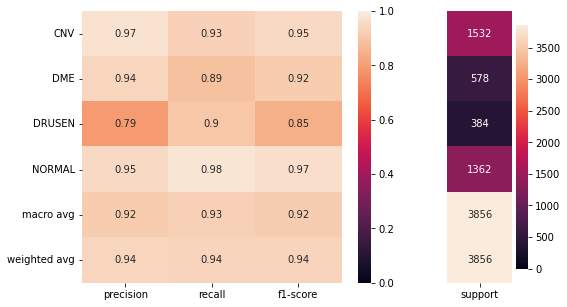

In [ ]:
# Nice looking version

# See more:
# https://stackoverflow.com/a/58948133/1071459
# https://stackoverflow.com/q/63931206/1071459

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5), gridspec_kw={"width_ratios": [8, 2]})
cmap = sns.diverging_palette(20, 145)
sns.heatmap(
    report_df.drop(columns="accuracy").iloc[:-1, :].T,
    vmin=0,
    vmax=1,
    annot=True,
    ax=ax1,
)
sns.heatmap(
    report_df.drop(columns="accuracy").iloc[-1:, :].T,
    vmin=0,
    annot=True,
    fmt=".0f",
    yticklabels=[],
    ax=ax2,
)
plt.show()

### Confusion matrix

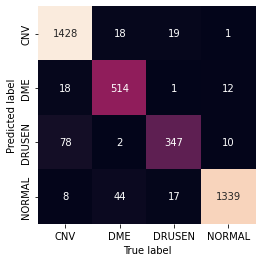

In [ ]:
mat = confusion_matrix(y_test, prediction_class)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=test_generator.class_indices,
    yticklabels=test_generator.class_indices,
)
plt.xlabel("True label")
plt.ylabel("Predicted label");

# Visualizing heatmaps

In [ ]:
def get_heatmaps(functional_model, last_conv_layer_name, img_batch, preprocess_function=None):
    """
    Matrix implementation of heatmap using Grad-CAM. Obtains heatmaps for the given images batches.

    Based on https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
    """
    img_batch_copy = np.copy(img_batch)
    if preprocess_function is not None:
        img_batch_copy = preprocess_function(img_batch_copy)

    with tf.GradientTape() as tape:
        last_conv_layer = functional_model.get_layer(last_conv_layer_name)
        iterate = tf.keras.models.Model(
            [functional_model.inputs], [functional_model.output, last_conv_layer.output]
        )
        model_out, last_conv_layer_out = iterate(img_batch_copy)
        max_pos_arr = np.argmax(model_out, axis=-1)
        class_out = [model_out[index, max_pos] for index, max_pos in enumerate(max_pos_arr)]
        grads = tape.gradient(class_out, last_conv_layer_out)
        pooled_grads = kbackend.mean(grads, axis=(1, 2))

    pooled_grads_expanded = tf.expand_dims(pooled_grads, axis=1)  # Expand once
    pooled_grads_expanded = tf.expand_dims(pooled_grads_expanded, axis=1)  # Expand twice
    heatmaps = tf.reduce_mean(tf.multiply(pooled_grads_expanded, last_conv_layer_out), axis=-1)
    heatmaps = np.maximum(heatmaps, 0)
    heatmaps_max_expanded = tf.expand_dims(np.max(heatmaps, axis=(1, 2)), axis=-1)  # Expand once
    heatmaps_max_expanded = tf.expand_dims(heatmaps_max_expanded, axis=-1)  # Expand twice
    heatmaps = heatmaps / heatmaps_max_expanded
    return heatmaps.numpy()

In [ ]:
# # Debug stuff
# def get_heatmap_old(model, last_conv_layer_name, img_batch):
#     # img_batch_first = np.expand_dims(img_batch[0], axis=0)  # Use only first image from batch

#     with tf.GradientTape() as tape:
#         last_conv_layer = model.get_layer(last_conv_layer_name)
#         iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
#         model_out, last_conv_layer_out = iterate(img_batch)
#         class_out = model_out[:, np.argmax(model_out[0])]
#         grads = tape.gradient(class_out, last_conv_layer_out)
#         pooled_grads = kbackend.mean(grads, axis=(1, 2))

#     heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_out), axis=-1)
#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= np.max(heatmap)
#     heatmap = heatmap.reshape((8, 8))
#     return heatmap

# x, y = test_generator[0]
# heatmaps = get_heatmaps(functional_model_for_testing, "conv5_block3_add", img_batch=x)
# plt.matshow(heatmaps[0])
# plt.matshow(get_heatmap_old(functional_model_for_testing, "conv5_block3_add", tf.expand_dims(x[0], 0)))
# plt.matshow(heatmaps[1])
# plt.matshow(get_heatmap_old(functional_model_for_testing, "conv5_block3_add", tf.expand_dims(x[1], 0)))
# plt.matshow(heatmaps[2])
# plt.matshow(get_heatmap_old(functional_model_for_testing, "conv5_block3_add", tf.expand_dims(x[2], 0)))
# plt.matshow(heatmaps[3])
# plt.matshow(get_heatmap_old(functional_model_for_testing, "conv5_block3_add", tf.expand_dims(x[3], 0)))
# plt.matshow(heatmaps[16])
# plt.matshow(get_heatmap_old(functional_model_for_testing, "conv5_block3_add", tf.expand_dims(x[16], 0)))

In [ ]:
def get_imgs_and_heatmaps(
    functional_model,
    last_conv_layer_name,
    img_batch,
    intensity=0.5,
    preprocess_function=None,
):
    """
    Returns images with the Grad-CAM heatmaps on top.

    Returns img_batch, img_batch_with_heatmap, heatmaps
    """
    heatmaps = get_heatmaps(
        functional_model,
        last_conv_layer_name,
        img_batch=img_batch,
        preprocess_function=preprocess_function,
    )

    img_batch_copy = np.copy(img_batch)
    img_batch_with_heatmap = np.zeros_like(img_batch_copy)
    for index, img in enumerate(img_batch_copy):
        heatmap_img = cv2.resize(heatmaps[index], (img.shape[1], img.shape[0]))
        heatmap_img = cv2.applyColorMap(np.uint8(255 * heatmap_img), cv2.COLORMAP_JET)
        img_with_heatmap = heatmap_img * intensity + img
        img_bgr = np.clip(img_with_heatmap, a_min=0, a_max=255)
        img_rgb = img_bgr[..., ::-1]
        img_batch_with_heatmap[index] = np.int0(img_rgb)

    return img_batch_copy, img_batch_with_heatmap, heatmaps

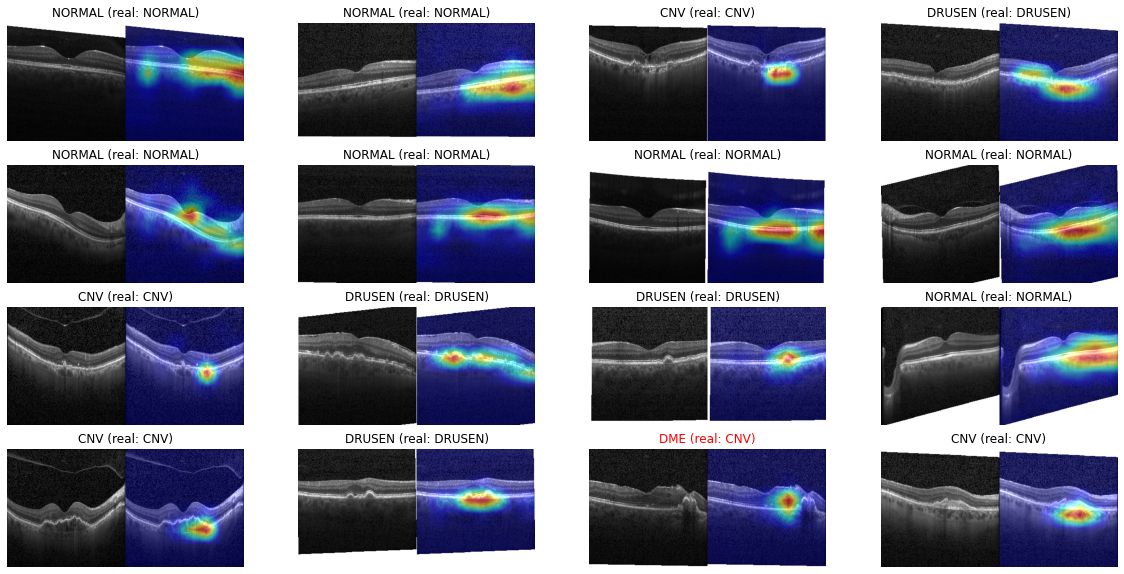

In [ ]:
batch_position = 0
x, y = test_generator[batch_position]
first_element_position = x.shape[0] * batch_position

working_imgs = image_gbr_to_rgb_uncenter(x)

# Possible conv like layers:
# conv5_block3_add, conv5_block3_out, conv5_block3_3_conv
img_batch, img_batch_with_heatmap, heatmaps = get_imgs_and_heatmaps(
    functional_model_for_testing,
    "conv5_block3_out",
    img_batch=working_imgs,
    preprocess_function=tf.keras.applications.resnet.preprocess_input,
    intensity=0.5,
)

composed_imgs = np.zeros((x.shape[0], x[0].shape[0], x[0].shape[1] * 2, 3))
for index, img in enumerate(img_batch):
    composition = np.concatenate((img, img_batch_with_heatmap[index]), axis=1)
    composition.shape = (img.shape[0], img.shape[1] * 2, 3)
    composed_imgs[index] = composition


class_indices = test_generator.class_indices
class_names = list(class_indices.keys())  # storing class/breed names in a list
plot_images(
    np.int0(composed_imgs),
    y,
    class_names,
    prediction_class[first_element_position : (first_element_position + x.shape[0])],
)

In [ ]:
# x, y = test_generator[0]
# position = 0
# working_img = x[position]

# a = test_generator.class_indices
# class_names = list(a.keys())  # storing class/breed names in a list
# print(class_names[np.argmax(y[position])])

# # Possible conv like layers:
# # conv5_block3_add, conv5_block3_out, conv5_block3_3_conv
# heatmap = get_heatmap_old(functional_model_for_testing, "conv5_block3_add", img_batch=np.expand_dims(working_img, axis=0))
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
# heatmap = heatmap.reshape((8, 8))
# plt.matshow(heatmap)
# plt.show()

# img_original = np.copy(working_img)
# img_tmp = image_gbr_to_rgb_uncenter(img_original)
# INTENSITY = 0.5
# heatmap_tmp = cv2.resize(heatmap, (img_tmp.shape[1], img_tmp.shape[0]))
# heatmap_tmp = cv2.applyColorMap(np.uint8(255 * heatmap_tmp), cv2.COLORMAP_JET)
# img = heatmap_tmp * INTENSITY + img_tmp
# cv2_imshow(img_tmp)
# cv2_imshow(img)

In [ ]:
# x, y = test_generator[0]
# position = 8
# working_img = x[position]

# a = test_generator.class_indices
# class_names = list(a.keys())  # storing class/breed names in a list
# print(class_names[np.argmax(y[position])])

# # Possible conv like layers:
# # conv5_block3_add, conv5_block3_out, conv5_block3_3_conv
# heatmap = get_heatmap(functional_model_for_testing, "conv5_block3_3_conv", img_batch=np.expand_dims(working_img, axis=0))
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
# heatmap = heatmap.reshape((8, 8))
# plt.matshow(heatmap)
# plt.show()

# img_original = np.copy(working_img)
# img_tmp = image_gbr_to_rgb_uncenter(img_original) * 255
# INTENSITY = 0.5
# heatmap_tmp = cv2.resize(heatmap, (img_tmp.shape[1], img_tmp.shape[0]))
# heatmap_tmp = cv2.applyColorMap(np.uint8(255 * heatmap_tmp), cv2.COLORMAP_JET)
# img = heatmap_tmp * INTENSITY + img_tmp
# cv2_imshow(img_tmp)
# cv2_imshow(img)